In [6]:
## Imports and Initialization -------------------------------------------------|
print("Importing dependencies... ")

import sys
import os, os.path
sys.path.append(os.path.abspath(".."))  # Adjust path to package root
import math

# third party
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# internal
import abstraction
import algorithm
from astropy.io import fits
from utility import IndexSchema, get_fits_paths, load_image_data
from examples.fits_to_mp4 import fits_to_mp4, data_to_mp4
from reference_method import ExternalRefs, RollingWindow

## Fetch Data ------------------------------------------------------------------

files_dir = os.path.abspath(os.path.join(".", "media", "large"))
files = get_fits_paths(files_dir)
files = files
# print("\n".join(files))
print(f"{len(files)} files found")

# variable paths for destretch results

kernel_sizes: np.ndarray[np.int64] = np.array([128, 64])
out_off_dir = os.path.join(files_dir, "off")
out_sum_dir = os.path.join(files_dir, "sum")
out_rolling_sum_dir = os.path.join(files_dir, "rolling_sum")
out_off_control_dir = os.path.join(files_dir, "off_control")
out_dir = os.path.join(files_dir, "destretched")
out_dir_control = os.path.join(files_dir, "destretched_control")
out_off_final_dir = os.path.join(files_dir, "off_final")

off_files = get_fits_paths(out_off_dir)
off_final_files = get_fits_paths(out_off_final_dir)
sum_files = get_fits_paths(out_sum_dir)
sum_avg_files = get_fits_paths(out_rolling_sum_dir)
rolling_sum_files = get_fits_paths(out_rolling_sum_dir)
file_count = len(off_files)


Importing dependencies... 
1400 files found


In [9]:
## generate graph data

test_data = load_image_data(off_files[0], z_index=None)
axis = 1

slice_width = len(off_files)
slice_height = test_data.shape[1]
slice_offset = math.floor(test_data.shape[2] * 0.25)
point_offset = math.floor(test_data.shape[1] * 0.5)
test_slice = test_data[axis, :, slice_offset]
print(f"slice size: ({slice_width, slice_height}), test slice height: {len(test_slice)}")


slice size: ((1400, 1000)), test slice height: 1000


# Offset Analysis

In [10]:
# load data into slices and point graph
slice_collage = np.zeros((slice_height, slice_width))
point_graph = np.zeros(slice_width)
for i in range(slice_width):
    slice_data = load_image_data(off_files[i], z_index=None)[axis, :, slice_offset]
    slice_collage[:,i] = slice_data
    sum_data = load_image_data(sum_files[i], z_index=None)
    point_graph[i] = slice_data[point_offset]
    if i % 100 == 0: # print progress every 100 steps
    	print(i)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [11]:
# rolling average across offset point graph
window_size = 25
rolling_avg_graph = np.zeros(len(point_graph))
for i in range(len(point_graph)):
    imin, imax = max(0, i - window_size), min(file_count, i + window_size)
    irange = imax - imin
    accumulator = 0.0
    for i2 in range(imin, imax):
        accumulator += point_graph[i2]
    accumulator /= irange
    rolling_avg_graph[i] = accumulator
    

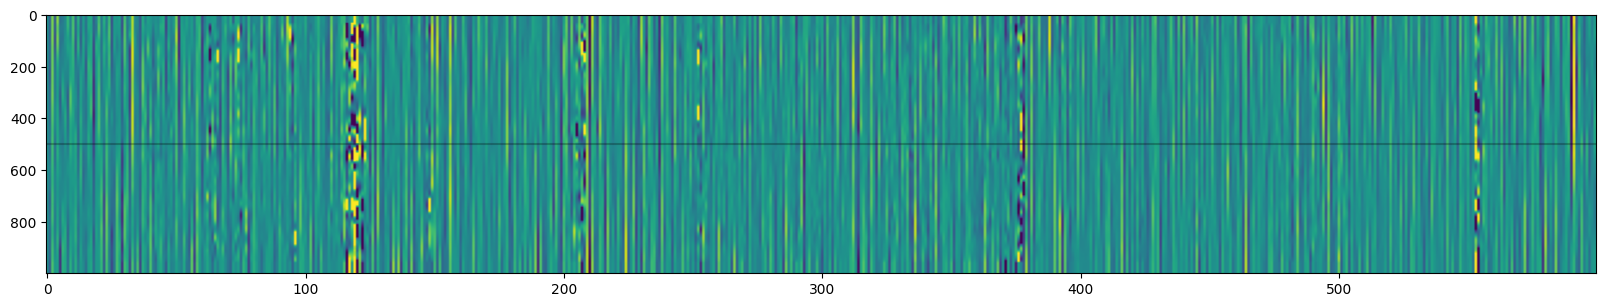

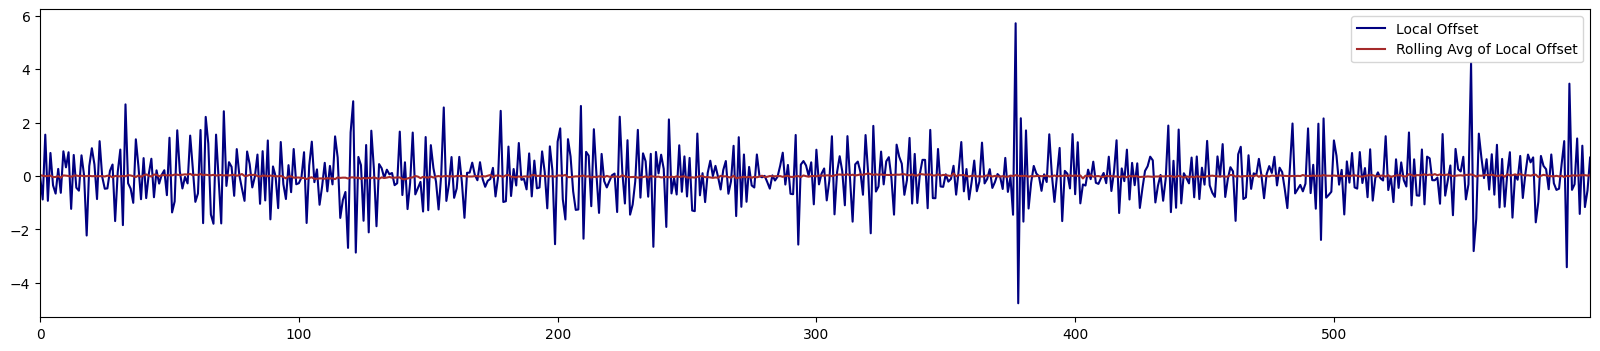

In [12]:
graph_range = 600

plt.figure(figsize=(20,4))
plt.imshow(slice_collage[:, :graph_range], vmin=-4, vmax=4, aspect=0.1)
plt.plot([0, graph_range-1], [point_offset, point_offset], color='black', alpha=0.25)
plt.show()

plt.figure(figsize=(20,4))
plt.plot(point_graph[:graph_range], color='navy', label="Local Offset")
plt.plot(rolling_avg_graph[:graph_range], color='brown', label="Rolling Avg of Local Offset")
plt.legend()
plt.xlim(0, graph_range-1)
plt.show()

# Cumulative Offset Analysis

In [13]:
# load cumulative sum points
sum_point_graph = np.zeros(slice_width)
sum_avg_destr_graph = np.zeros(slice_width)
for i in range(slice_width):
    sum_data = load_image_data(sum_files[i], z_index=None)
    sum_point_graph[i] = sum_data[axis, point_offset, slice_offset]
    sum_avg_data = load_image_data(sum_avg_files[i], z_index=None)
    sum_avg_destr_graph[i] = sum_avg_data[axis, point_offset, slice_offset]
    if i % 100 == 0: # print progress every 100 steps
    	print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [ ]:
# create plot estimate of rolling average across cumulative sum point graph
window_size = 25
sum_avg_est_graph = np.zeros(len(sum_point_graph))
for i in range(file_count):
    imin, imax = max(0, i - window_size), min(file_count, i + window_size)
    irange = imax - imin
    accumulator = 0.0
    for i2 in range(imin, imax):
        accumulator += sum_point_graph[i2]
    accumulator /= irange
    sum_avg_est_graph[i] = accumulator
    
# flow 
flow_est_graph = np.zeros(slice_width)
window_size = 5
for i in range(slice_width):
    imin, imax = max(0, i - window_size), min(slice_width, i + window_size)
    flow_est_graph[i] = sum_avg_est_graph[min(slice_width-1, i+window_size)] - sum_avg_est_graph[max(0, i-window_size)]

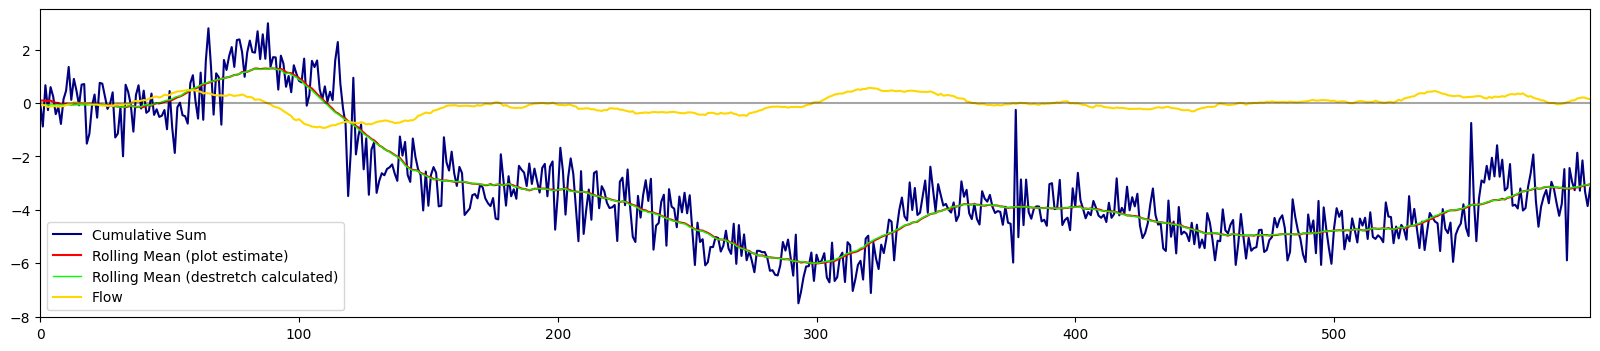

In [29]:

plt.figure(figsize=(20,4))
plt.plot(sum_point_graph[:graph_range], color='navy', label="Cumulative Sum")
plt.plot(sum_avg_est_graph[:graph_range], color='red', label="Rolling Mean (plot estimate)")
plt.plot(sum_avg_destr_graph[:graph_range], linewidth=1, color='lime', label="Rolling Mean (destretch calculated)")
plt.plot(flow_est_graph[:graph_range], color='gold', label="Flow")
plt.plot([0, graph_range], [0, 0], color='black', alpha=0.35)
plt.xlim(0, graph_range-1)
plt.legend()
plt.show()


# Corrected Offset Analysis

In [30]:
# load corrected offsets
corr_off_graph = np.zeros(slice_width)
corr_off_est_graph = np.zeros(slice_width)
for i in range(slice_width):
    data_corr = load_image_data(off_final_files[i], z_index=None)
    corr_off_graph[i] = data_corr[axis, point_offset, slice_offset]
    corr_off_est_graph[i] = sum_point_graph[i] - sum_avg_est_graph[i]
    if i % 100 == 0: # print progress every 100 steps
    	print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


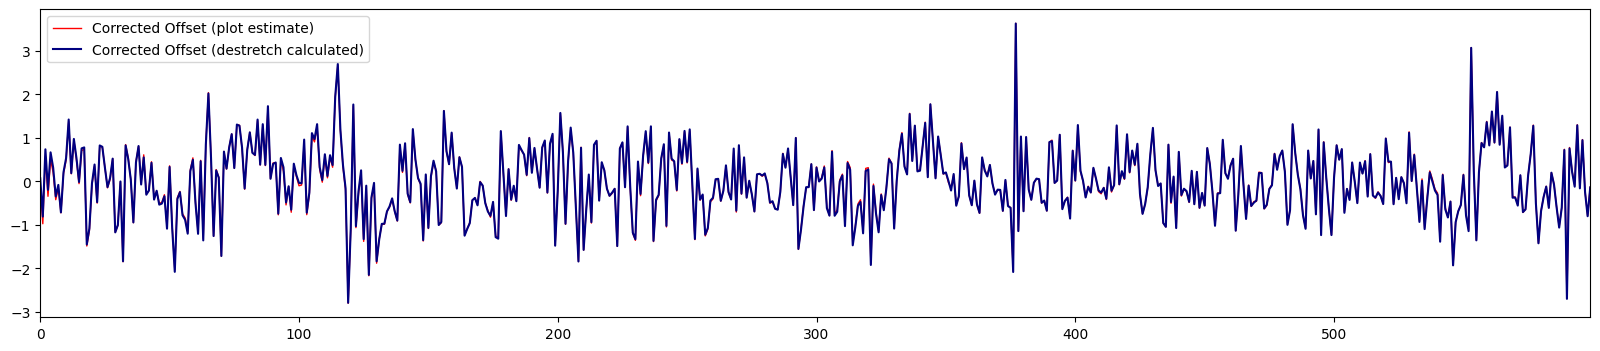

In [31]:
plt.figure(figsize=(20,4))
plt.plot(corr_off_est_graph[:graph_range], linewidth=1, color='red', label="Corrected Offset (plot estimate)")
plt.plot(corr_off_graph[:graph_range], color='navy', label="Corrected Offset (destretch calculated)")
plt.xlim(0, graph_range-1)
plt.legend()
plt.show()